In [18]:
import numpy as np
import pyuvdata
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
import array_sensitivity
import importlib
importlib.reload(array_sensitivity)
from matplotlib.patches import Rectangle
import scipy

In [2]:
# Set instrument parameters
antpos_filepath = "20210226W.cfg"
c = 3e8
min_freq_hz = 0.7e9
max_freq_hz = c / 0.21
freq_hz = np.mean([min_freq_hz, max_freq_hz])
tsys_k = 25
aperture_efficiency = 0.62
field_of_view_deg2 = 10.6
antenna_diameter_m = 5
freq_resolution_hz = 162.5e3
int_time_s = 15.0 * 60  # 15 minutes in each survey field
max_bl_m = 1000.
bao_scales_k = np.array([.03, .2]) / 0.71

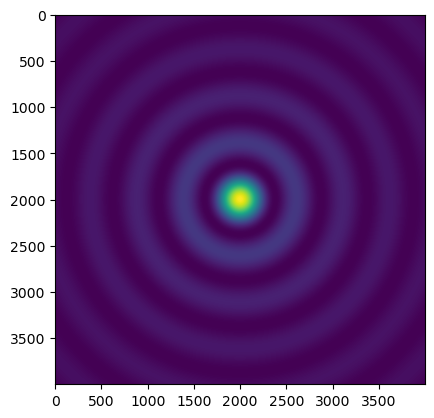

In [15]:
resolution_deg = 1e-3
image_extent_deg = 2.
ew_axis = np.arange(0, image_extent_deg, resolution_deg)
ew_axis = np.append(-(ew_axis[::-1])[:-1], ew_axis)
ns_axis = np.copy(ew_axis)
ew_vals, ns_vals = np.meshgrid(ew_axis, ns_axis)

beam = scipy.special.jv(0, 2.*np.pi*np.sqrt(ew_vals**2. + ns_vals**2.))
plt.imshow(np.abs(beam)**2.)

In [ ]:
psf, frequencies, ew_axis, ns_axis = array_sensitivity.calculate_psf(
    baselines_m=baselines_m,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    freq_resolution_hz=freq_resolution_hz,
    antenna_diameter_m=antenna_diameter_m,
)

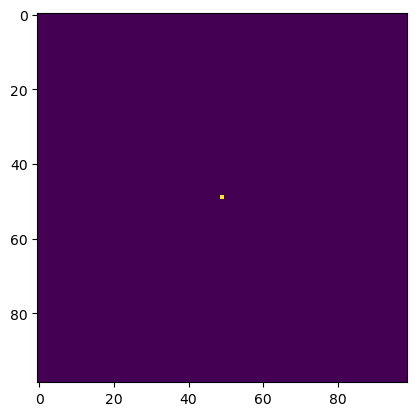

In [11]:
plt.imshow(psf)

In [3]:
antpos = array_sensitivity.get_antpos(antpos_filepath)

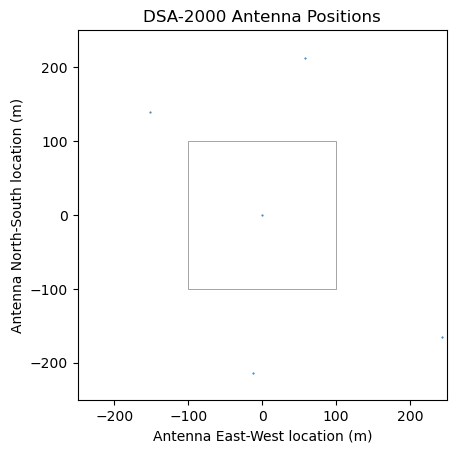

In [4]:
fig, ax = plt.subplots()
ax.plot(antpos[:,0], antpos[:,1], marker="o", markersize=.5, linewidth=0)
ax.set_aspect(1)
ax.set_xlabel("Antenna East-West location (m)")
ax.set_ylabel("Antenna North-South location (m)")
ax.set_title("DSA-2000 Antenna Positions")
ax.add_patch(
    Rectangle((-100, -100), 200, 200, edgecolor = 'grey', fill=False, lw=0.5)         
)
ax.set_aspect("equal")
#plt.savefig("plots/antlocs.png", dpi=600)
plt.xlim([-250, 250])
plt.ylim([-250, 250])
plt.show()

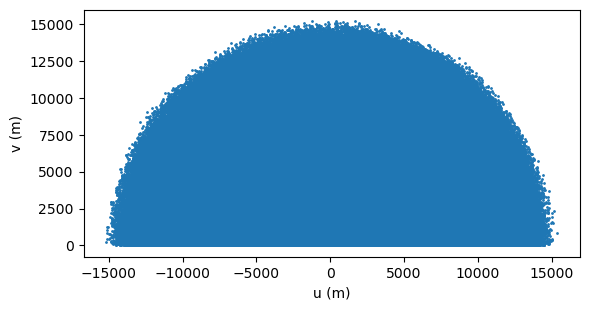

In [5]:
# Get baselines
baselines_m = array_sensitivity.get_baselines(antpos)
fig, ax = plt.subplots()
ax.scatter(baselines_m[:,0], baselines_m[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("u (m)")
ax.set_ylabel("v (m)")
plt.show()

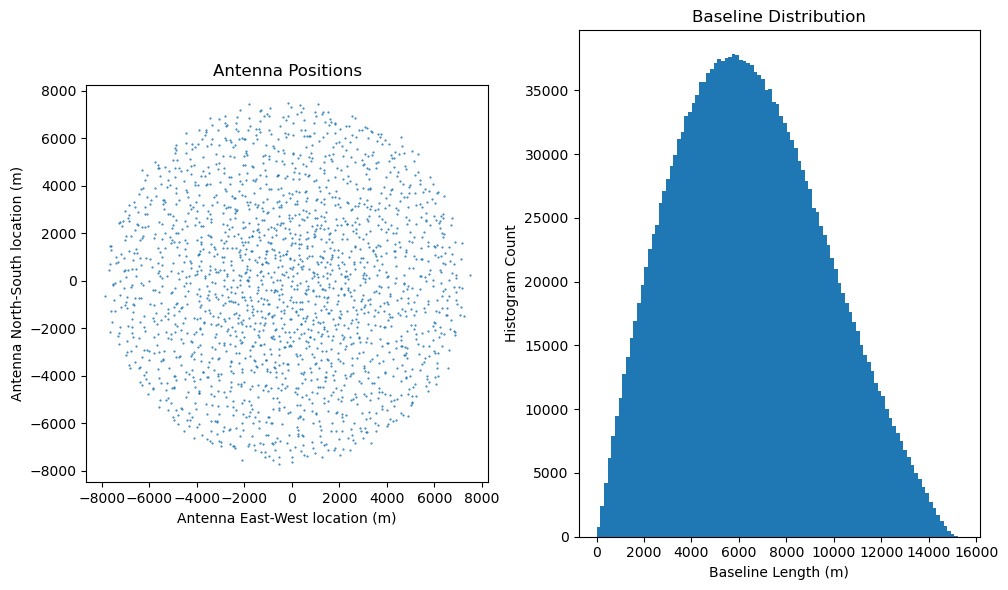

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

ax[0].plot(antpos[:,0], antpos[:,1], marker="o", markersize=.5, linewidth=0)
ax[0].set_aspect(1)
ax[0].set_xlabel("Antenna East-West location (m)")
ax[0].set_ylabel("Antenna North-South location (m)")
ax[0].set_title("Antenna Positions")
ax[0].set_aspect("equal")

ax[1].hist(np.sqrt(np.sum(baselines_m**2., axis=1)), bins=100)
ax[1].set_xlabel("Baseline Length (m)")
ax[1].set_ylabel("Histogram Count")
ax[1].set_title("Baseline Distribution")

plt.tight_layout()
plt.savefig("plots/antlocs.png", dpi=600)
plt.show()

In [8]:
# Define bin edges:
freq_array_hz = np.arange(min_freq_hz, max_freq_hz, freq_resolution_hz)
delay_array_s = np.fft.fftshift(
    np.fft.fftfreq(len(freq_array_hz), d=freq_resolution_hz)
)
kpar_conv_factor = array_sensitivity.get_kpar_conversion_factor(freq_hz)
max_kpar = kpar_conv_factor * np.max(delay_array_s)

kperp_conv_factor = array_sensitivity.get_kperp_conversion_factor(freq_hz)
max_baseline_wl = np.max(np.sqrt(np.sum(baselines_m**2.0, axis=1))) * max_freq_hz / c
max_kperp = kperp_conv_factor * max_baseline_wl
max_k = np.sqrt(max_kpar**2.0 + max_kperp**2.0)

k_bin_size = 0.1
min_k = 0.
bin_edges = np.arange(min_k, max_k, k_bin_size)
kpar_bin_edges = np.arange(0, max_kpar, k_bin_size)
kperp_bin_edges = np.arange(0, max_kperp, k_bin_size)

# For debugging
bin_edges = bin_edges[:50]

In [9]:
if False:  # Use saved simulation
    with open("simulation_outputs/zenith_thermal_noise.npy", "rb") as f:
        nsamples = np.load(f)
        binned_ps_variance = np.load(f)
        true_bin_edges = np.load(f)
        true_bin_centers = np.load(f)
        nsamples_2d = np.load(f)
        binned_ps_variance_2d = np.load(f)
    f.close()

In [17]:
(
    nsamples,
    binned_ps_variance,
    true_bin_edges,
    true_bin_centers,
    nsamples_2d,
    binned_ps_variance_2d,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=max_bl_m,
    k_bin_edges_1d=bin_edges,
    kpar_bin_edges=kpar_bin_edges,
    kperp_bin_edges=kperp_bin_edges,
    wedge_extent_deg=1.84,
    zenith_angle=0.0,
)

/Users/ruby/Astro/PSsensitivity/array_sensitivity.py:311: RuntimeWarning: divide by zero encountered in true_divide
  binned_ps_variance_2d = ps_variance / nsamples_2d


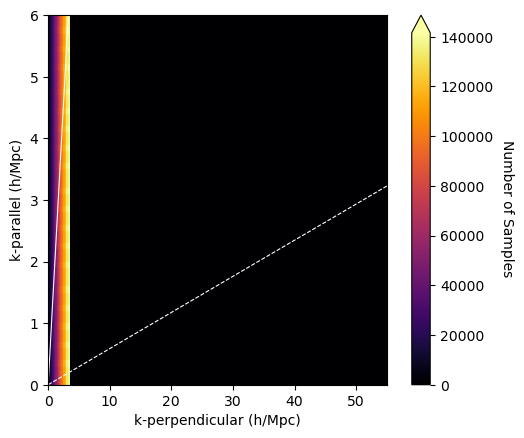

In [18]:
# Make 2D Nsamples plot

# Get wedge slope
kperp_conv_factor = array_sensitivity.get_kperp_conversion_factor(freq_hz)
kpar_conv_factor = array_sensitivity.get_kpar_conversion_factor(freq_hz)
wedge_slope = kpar_conv_factor / (kperp_conv_factor * freq_hz)

field_of_view_radius = np.sqrt(field_of_view_deg2 / np.pi)
fov_wedge_slope = wedge_slope * np.sin(np.radians(field_of_view_radius))

fig, ax = plt.subplots()
use_cmap = cm.get_cmap("inferno").copy()
cax = ax.imshow(
    nsamples_2d.T,
    origin="lower",
    interpolation="none",
    extent=[np.min(kperp_bin_edges), np.max(kperp_bin_edges), np.min(kpar_bin_edges), np.max(kpar_bin_edges)],
    vmin=0,
    vmax=np.max(nsamples_2d),
    cmap=use_cmap,
    #norm="log",
    aspect=10.,
)
ax.set_xlabel("k-perpendicular (h/Mpc)")
ax.set_ylabel("k-parallel (h/Mpc)")
ax.set_xlim([0, 55])
ax.set_ylim([0, np.max(kpar_bin_edges)])
plt.plot([0, 55], [0, wedge_slope*55], c="white", linewidth=.8)
plt.plot([0, 55], [0, fov_wedge_slope*55], "--", c="white", linewidth=.8)
#ax.grid(linewidth=.5)
cbar = fig.colorbar(cax, extend="max")
cbar.set_label("Number of Samples", rotation=270, labelpad=15)
plt.savefig("plots/2d_nsampes.png", dpi=600)
plt.show()

In [ ]:
print(field_of_view_radius)

In [19]:
# Load CAMB power spectrum data
f = open("camb_49591724_matterpower_z0.5.dat", "r")
file_data = f.readlines()
f.close()
model_k_axis = []
ps_model_unnorm = []
for line in file_data:
    model_k_axis.append(float(line.split()[0]))
    ps_model_unnorm.append(float(line.split()[1]))
ps_model = array_sensitivity.matter_ps_to_21cm_ps_conversion(
    np.array(model_k_axis),
    np.array(ps_model_unnorm),
    0.5
)

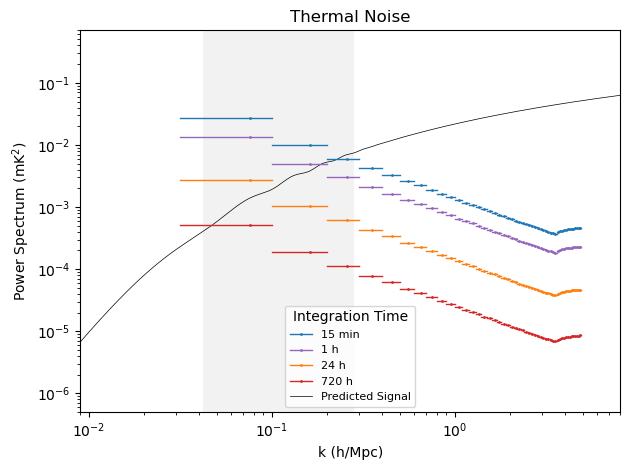

In [20]:
plot_integration_times_h = [.25, 1, 24, 720]
colors = ['tab:blue','tab:purple','tab:orange','tab:red']
legend_labels = [
    "15 min",
    "1 h",
    "24 h",
    "720 h",
    "Predicted Signal",
]
xrange = [.9e-2, 8]
yrange = [5e-7, 7e-1]

legend_lines = [Line2D([0], [0], linewidth=1, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]

# Plot theory line
plt.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

# Plot BAO scales
plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

for int_time_ind, int_time in enumerate(plot_integration_times_h):
    plot_vals = np.sqrt(binned_ps_variance * .25 / int_time)
    plt.plot(
        true_bin_centers,
        plot_vals,
        marker="o", markersize=1, linewidth=0,
        color=colors[int_time_ind],
    )
    for bin_ind in range(len(plot_vals)):  
        plt.plot(
            true_bin_edges[bin_ind, :],
            [plot_vals[bin_ind], plot_vals[bin_ind]],
            marker="none",
            linewidth=1,
            color=colors[int_time_ind],
        )
plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum (mK$^2$)")
plt.legend(legend_lines, legend_labels, prop={'size': 8}, title="Integration Time")
plt.title("Thermal Noise")
plt.tight_layout()
plt.savefig("plots/thermal_noise_stddev.png")
plt.show()

In [21]:
uv_extent = 4000
binned_ps_sample_variance = array_sensitivity.get_sample_variance(
    ps_model,  # Units mK^2
    model_k_axis,  # Units h/Mpc
    field_of_view_deg2=field_of_view_deg2,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    freq_resolution_hz=freq_resolution_hz,
    k_bin_edges=bin_edges,
    wedge_extent_deg=1.84,
)

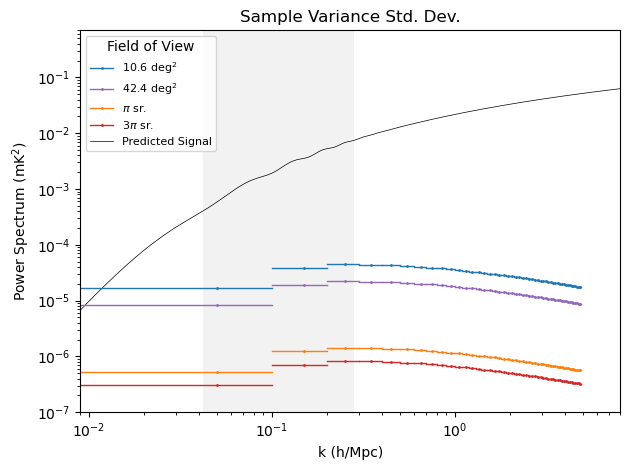

In [27]:
plot_fov_deg = [10.6, 42.4, np.pi*(180/np.pi)**2., 3*np.pi*(180/np.pi)**2.]
colors = ['tab:blue', 'tab:purple', 'tab:orange', 'tab:red']
legend_labels = [
    "10.6 deg$^2$",
    "42.4 deg$^2$",
    "$\pi$ sr.",
    "3$\pi$ sr.",
    "Predicted Signal",
]
xrange = [.9e-2, 8]
yrange = [1e-7, 7e-1]

legend_lines = [Line2D([0], [0], linewidth=1, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")] 

# Plot theory line
plt.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

# Plot BAO scales
plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

for fov_ind, use_fov in enumerate(plot_fov_deg):
    plot_vals = np.sqrt(binned_ps_sample_variance * field_of_view_deg2 / use_fov)
    plt.plot(
        (bin_edges[:-1] + bin_edges[1:]) / 2,
        plot_vals,
        marker="o", markersize=1, linewidth=0,
        color=colors[fov_ind],
    )
    for bin_ind in range(len(plot_vals)):  
        plt.plot(
            [bin_edges[bin_ind], bin_edges[bin_ind + 1]],
            [plot_vals[bin_ind], plot_vals[bin_ind]],
            marker="none",
            linewidth=1,
            color=colors[fov_ind],
        )
plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum (mK$^2$)")
plt.legend(legend_lines, legend_labels, prop={'size': 8}, title="Field of View")
plt.title("Sample Variance Std. Dev.")
plt.tight_layout()
plt.savefig("plots/sample_stddev.png")
plt.show()

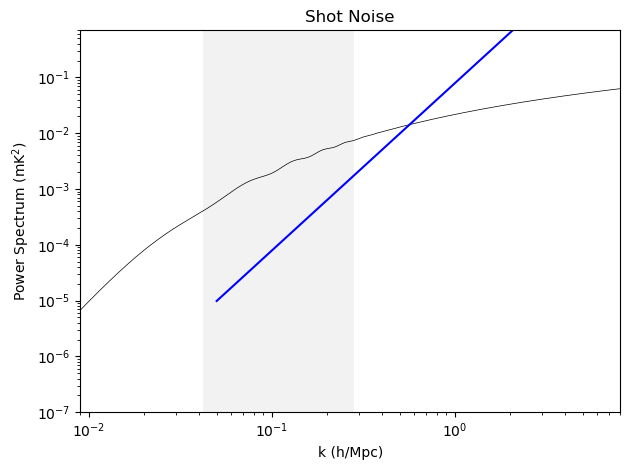

In [28]:
# Get shot noise
shot_noise = array_sensitivity.get_shot_noise(
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    k_bin_edges=bin_edges,
)

xrange = [.9e-2, 8]
yrange = [1e-7, 7e-1]

# Plot theory line
plt.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

# Plot BAO scales
plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, np.sqrt(shot_noise), color="blue")
plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum (mK$^2$)")
plt.title("Shot Noise")
plt.tight_layout()
plt.savefig("plots/shot_noise.png")
plt.show()

In [30]:
brightness_temp_zp5 = array_sensitivity.get_brightness_temp(.5)
print(brightness_temp_zp5)
brightness_temp_z1 = array_sensitivity.get_brightness_temp(1)
print(brightness_temp_z1)

0.14283392062657765
0.1913582887700535


In [33]:
brightness_temp_z1**2. / .01 * .1**3 / 2 / np.pi**2

0.00018550892818440363

In [ ]:
combined_variance_single_field = binned_ps_variance + binned_ps_sample_variance
combined_variance_all_sky = (
    (binned_ps_variance * .25 / 720) 
    + (binned_ps_sample_variance * field_of_view_deg2 / (3*np.pi*(180/np.pi)**2.))
)

In [ ]:
colors = ['tab:blue', 'tab:red']
legend_labels = [
    "15 min, 10.6 deg$^2$",
    "720 h, 3$\pi$ sr.",
    "Predicted Signal",
]
xrange = [1e-2, 8]
yrange = [2e-6, 7e-1]

legend_lines = [Line2D([0], [0], linewidth=1, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]

# Plot theory line
plt.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

# Plot BAO scales
plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

for data_ind, plot_vals in enumerate(np.sqrt([combined_variance_single_field, combined_variance_all_sky])):
    plt.plot(
        true_bin_centers,
        plot_vals,
        marker="o", markersize=1, linewidth=0,
        color=colors[data_ind],
    )
    for bin_ind in range(len(plot_vals)):  
        plt.plot(
            true_bin_edges[bin_ind, :],
            [plot_vals[bin_ind], plot_vals[bin_ind]],
            marker="none",
            linewidth=1,
            color=colors[data_ind],
        )
plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum (mK$^2$)")
plt.legend(legend_lines, legend_labels, prop={'size': 8}, title="Observation Parameters")
plt.title("Combined Noise Std. Dev.")
plt.tight_layout()
plt.savefig("plots/combined_noise_stddev.png")
plt.show()

# Off-Zenith Analysis
Look at a zenith angle of 60 degrees

In [ ]:
(
    nsamples_offzenith,
    binned_ps_variance_offzenith,
    true_bin_edges_offzenith,
    true_bin_centers_offzenith,
    nsamples_2d_offzenith,
    binned_ps_variance_2d_offzenith,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=max_bl_m,
    k_bin_edges_1d=bin_edges,
    kpar_bin_edges=kpar_bin_edges,
    kperp_bin_edges=kperp_bin_edges,
    zenith_angle=60.
)

In [ ]:
combined_variance_single_field_offzenith = binned_ps_variance_offzenith + binned_ps_sample_variance
combined_variance_all_sky_offzenith = (
    (binned_ps_variance_offzenith * .25 / 720) 
    + (binned_ps_sample_variance * field_of_view_deg2 / (3*np.pi*(180/np.pi)**2.))
)

In [ ]:
colors = ['tab:blue', 'tab:red']
legend_labels = [
    "15 min, 10.6 deg$^2$",
    "720 h, 3$\pi$ sr.",
    "Predicted Signal",
]
xrange = [1e-2, 8]
yrange = [2e-6, 7e-1]

legend_lines = [Line2D([0], [0], linewidth=1, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]

# Plot theory line
plt.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

# Plot BAO scales
plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

for data_ind, plot_vals in enumerate(np.sqrt([combined_variance_single_field_offzenith, combined_variance_all_sky_offzenith])):
    plt.plot(
        true_bin_centers_offzenith,
        plot_vals,
        marker="o", markersize=1, linewidth=0,
        color=colors[data_ind],
    )
    for bin_ind in range(len(plot_vals)):  
        plt.plot(
            true_bin_edges_offzenith[bin_ind, :],
            [plot_vals[bin_ind], plot_vals[bin_ind]],
            marker="none",
            linewidth=1,
            color=colors[data_ind],
        )
plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum (mK$^2$)")
plt.legend(legend_lines, legend_labels, prop={'size': 8}, title="Observation Parameters")
plt.title("Combined Noise Std. Dev., Off-Axis Observation")
plt.tight_layout()
plt.savefig("plots/combined_noise_stddev_offzenith.png")
plt.show()